# Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Preparing the data

In [2]:
# Hent og behandle data før trening.
# Split inn i test_set og train_set
# normalisere data
# behandle manglende data
# lag dette i en pipeline (se boka)
# lage kateogirer dersom nødvendig? Legge til atributes som kan være hensiktsmessig å ha

## Read The Data
First, we need to take a look at the data structure and attributes.
We want to find correlations that can predict useful information. 

In [9]:
import pandas as pd

CSV_FILENAME = "steel_plate.csv" 
CSV_FOLDER_NAME = "Datasets"
CSV_FILEPATH = os.path.join(CSV_FOLDER_NAME, CSV_FILENAME)

try:
    raw_data = pd.read_csv(CSV_FILEPATH)
except Exception as e:
    print(e)

raw_data.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [12]:
raw_data.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.083288,-0.131305,0.585420,0.081401,0.097888,0.201443,0.037094,0.028336,0.207110,0.346728
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.500868,0.148767,0.339452,0.273521,0.297239,0.401181,0.189042,0.165973,0.405339,0.476051
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,-0.333300,-0.195000,0.248200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.095200,-0.133000,0.506300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.511600,-0.066600,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


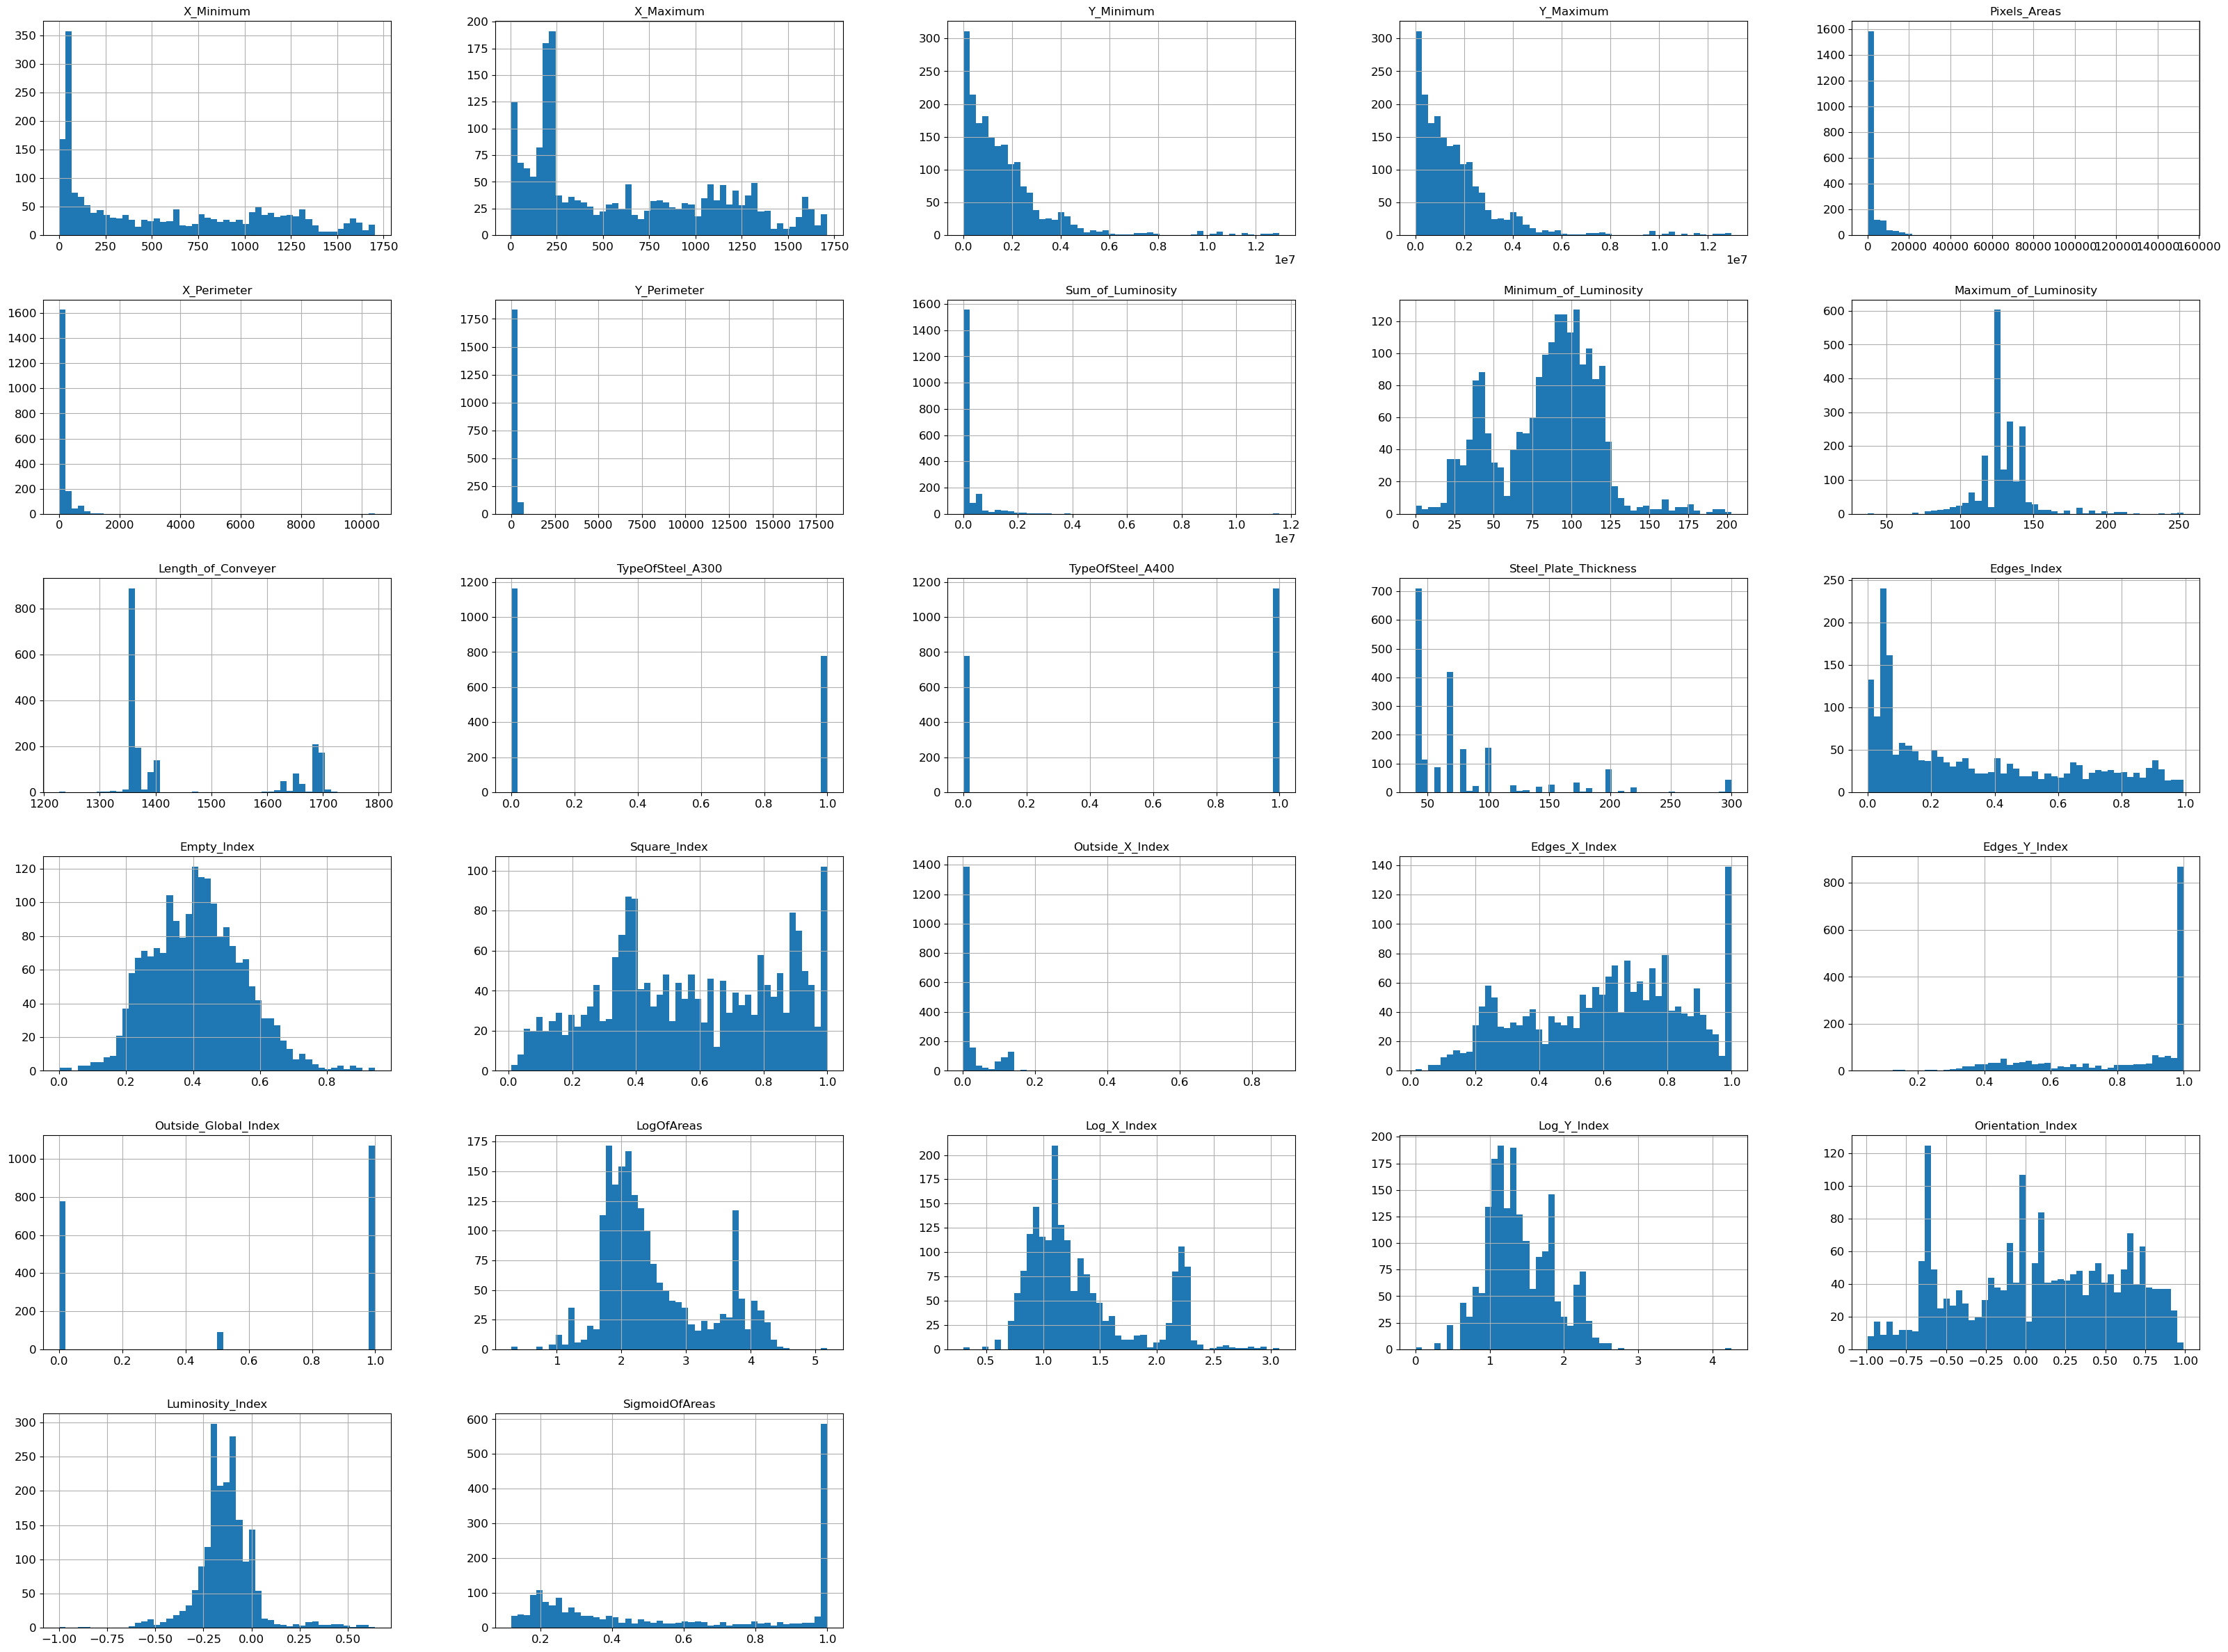

In [31]:
import matplotlib.pyplot as plt

selected_atributes = raw_data[["X_Minimum","X_Maximum","Y_Minimum","Y_Maximum","Pixels_Areas","X_Perimeter","Y_Perimeter","Sum_of_Luminosity","Minimum_of_Luminosity","Maximum_of_Luminosity","Length_of_Conveyer","TypeOfSteel_A300","TypeOfSteel_A400","Steel_Plate_Thickness","Edges_Index","Empty_Index","Square_Index","Outside_X_Index","Edges_X_Index","Edges_Y_Index","Outside_Global_Index","LogOfAreas","Log_X_Index","Log_Y_Index","Orientation_Index","Luminosity_Index","SigmoidOfAreas"]]
selected_atributes.hist(bins=50, figsize=(40,30))
plt.show()

In [14]:
# Look for NaN values
nan_per_column = raw_data.isna().sum()
nan_per_column

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

## Create test set and train set

In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=21) #TODO: trenger vi å bruke stratified sampling på noen parametre?

print(f"Length test set: {len(test_set)} \nLength train set: {len(train_set)}")

Length test set: 389 
Length train set: 1552


## Look for corelations

array([[<Axes: xlabel='X_Minimum', ylabel='X_Minimum'>,
        <Axes: xlabel='X_Maximum', ylabel='X_Minimum'>,
        <Axes: xlabel='Y_Minimum', ylabel='X_Minimum'>,
        <Axes: xlabel='Y_Maximum', ylabel='X_Minimum'>,
        <Axes: xlabel='Pixels_Areas', ylabel='X_Minimum'>,
        <Axes: xlabel='Sum_of_Luminosity', ylabel='X_Minimum'>,
        <Axes: xlabel='Minimum_of_Luminosity', ylabel='X_Minimum'>,
        <Axes: xlabel='Maximum_of_Luminosity', ylabel='X_Minimum'>,
        <Axes: xlabel='Length_of_Conveyer', ylabel='X_Minimum'>,
        <Axes: xlabel='Steel_Plate_Thickness', ylabel='X_Minimum'>,
        <Axes: xlabel='Stains', ylabel='X_Minimum'>],
       [<Axes: xlabel='X_Minimum', ylabel='X_Maximum'>,
        <Axes: xlabel='X_Maximum', ylabel='X_Maximum'>,
        <Axes: xlabel='Y_Minimum', ylabel='X_Maximum'>,
        <Axes: xlabel='Y_Maximum', ylabel='X_Maximum'>,
        <Axes: xlabel='Pixels_Areas', ylabel='X_Maximum'>,
        <Axes: xlabel='Sum_of_Luminosity', ylab

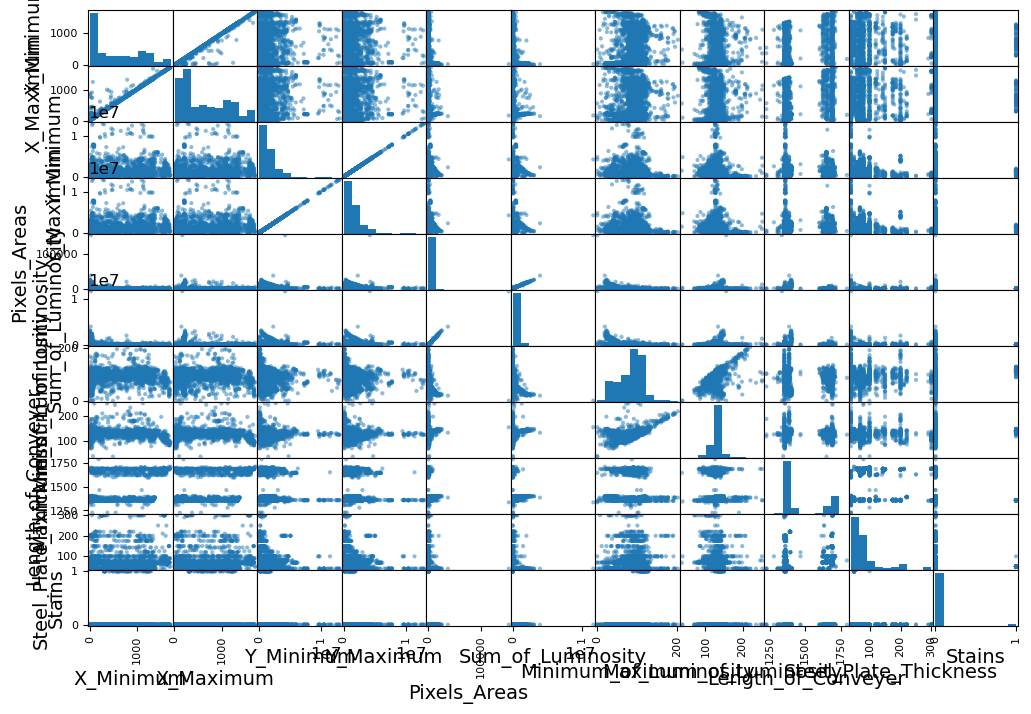

In [38]:
corr_matrix = raw_data.corr()
corr_matrix["X_Minimum"]

from pandas.plotting import scatter_matrix
selected_atributes = raw_data[["X_Minimum","X_Maximum","Y_Minimum","Y_Maximum","Pixels_Areas","Sum_of_Luminosity","Minimum_of_Luminosity","Maximum_of_Luminosity","Length_of_Conveyer","Steel_Plate_Thickness", "Stains"]]

# Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults

scatter_matrix(selected_atributes.copy(), figsize=(12, 8))

## Preparing The Data For Training
Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

target_columns = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]

columns_to_scale = [col for col in train_set.columns if col not in target_columns]

scaler = StandardScaler()
train_set[columns_to_scale] = scaler.fit_transform(train_set[columns_to_scale])

X = train_set[columns_to_scale]
y = train_set[target_columns]

train_set


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
332,-0.860277,-0.893338,-0.425574,-0.425592,-0.254165,-0.029301,-0.062511,-0.262512,1.079996,0.254596,...,-1.375716,0.832056,1.192738,0,1,0,0,0,0,0
750,1.228194,1.209407,-0.165534,-0.165564,-0.362274,-0.330843,-0.178434,-0.402357,1.172101,0.307535,...,-1.501911,0.945925,-1.332208,0,0,0,1,0,0,0
110,1.325911,1.315952,-0.635339,-0.635348,-0.327550,-0.288201,-0.119419,-0.364652,0.005440,-0.221851,...,1.152405,-0.163124,-0.023675,1,0,0,0,0,0,0
664,-1.009727,-0.810917,0.386387,0.386388,0.664944,0.525050,0.150366,0.692742,-1.345430,-0.274789,...,-1.400794,-0.342351,1.205982,0,0,1,0,0,0,0
794,0.013432,-0.071137,-0.261339,-0.261367,-0.361737,-0.336935,-0.176326,-0.401776,0.650174,0.678104,...,-0.498768,0.734357,-1.325145,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,1.854735,1.872797,-0.935116,-0.935134,-0.348671,-0.318660,-0.161573,-0.391929,-0.516487,-1.598253,...,-0.164320,-1.450726,-0.976968,1,0,0,0,0,0,0
772,0.151386,0.101747,-0.675909,-0.675930,-0.352788,-0.291247,-0.159465,-0.391801,0.251053,0.095781,...,-0.966835,0.115149,-0.566690,0,0,0,1,0,0,0
1848,-0.852613,-0.973749,-0.849214,-0.849219,-0.338826,-0.306476,-0.104665,-0.368156,1.479117,1.101613,...,1.340394,1.610951,-0.159061,0,0,0,0,0,0,1
1231,1.050003,1.074719,1.620024,1.619984,-0.333457,-0.199870,-0.119419,-0.367972,0.619472,0.201658,...,-1.368092,0.361754,0.551421,0,0,0,0,0,1,0


# Training a Model

In [8]:
# Prøv ulike mdoeller og sjekk hvor godt de fungerer
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Tren modellen på treningsdata
clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Gjør prediksjoner på testsettet
y_pred = clf.predict(X)

# Beregn nøyaktighet
accuracy = accuracy_score(y_test, y_pred)
print(f"Modellens nøyaktighet: {accuracy:.2f}")

# Vis detaljerte resultater
print(classification_report(y_test, y_pred))

In [62]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [63]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [0.19657973 0.20308022 0.19874723 0.20201656 0.22469929 0.19796104
 0.20405656 0.20135486 0.22408154 0.21487795]
Mean: 0.206745496237982
Standard deviation: 0.010027871374869685


# Fine Tuning

In [8]:
# bruk grid search for å finne beste kombinasjone av hyperparameters

# Mi BOMBOCLAT